In [1]:
pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import os

In [3]:
''' "Write a Python script that reads multiple CSV files from a local folder and automatically uploads the data into corresponding MySQL tables. The script should:

Use pandas to read the CSV files

Infer column data types and create the tables dynamically if they don't exist

Replace NaN with NULL values for SQL

Use mysql.connector to connect to a MySQL database

Use parameterized queries to safely insert data row by row

Clean column names by replacing spaces, dashes, and dots with underscores

Show some debug output like NaN count per file

Commit changes after each file and close the connection at the end

Assume I have files like 'orders.csv', 'customers.csv', etc., and I want to map each CSV to a table with the same name in a database named 'ecommerce'. Also, infer proper SQL data types based on the pandas dtypes."** '''

' "Write a Python script that reads multiple CSV files from a local folder and automatically uploads the data into corresponding MySQL tables. The script should:\n\nUse pandas to read the CSV files\n\nInfer column data types and create the tables dynamically if they don\'t exist\n\nReplace NaN with NULL values for SQL\n\nUse mysql.connector to connect to a MySQL database\n\nUse parameterized queries to safely insert data row by row\n\nClean column names by replacing spaces, dashes, and dots with underscores\n\nShow some debug output like NaN count per file\n\nCommit changes after each file and close the connection at the end\n\nAssume I have files like \'orders.csv\', \'customers.csv\', etc., and I want to map each CSV to a table with the same name in a database named \'ecommerce\'. Also, infer proper SQL data types based on the pandas dtypes."** '

In [4]:
# list of csv files and their corresponding table name

csv_files = [('customers.csv','customers'),
             ('orders.csv','orders'),
             ('sellers.csv','sellers'),
             ('products.csv','products'),
             ('geolocation.csv','geolocation'),
             ('payments.csv','payments'),
             ('order_items.csv','order_items')
            ]

# connect to Mysql database

conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Faiqua@123',
    database='ecommerce',
)

cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r'C:\Users\faiqu\OneDrive\Desktop\Faiqua Folder\ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

#processing each csv file
for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [5]:
db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Faiqua@123",
                            database = "ecommerce")

cur = db.cursor()

# List all unique cities where customers are located.

In [6]:
cur.execute("select distinct customer_city from customers")

data=cur.fetchall()

df=pd.DataFrame(data)
df.head(10)



,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


In [7]:
query="select count( distinct customer_city) from customers"

data=pd.read_sql(query,db)
print (data)

C:\Users\faiqu\AppData\Local\Temp\ipykernel_14004\4191078077.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data=pd.read_sql(query,db)


   count( distinct customer_city)
0                            4119


# Count the number of orders placed in 2017.

In [8]:
query="""select count(order_id) from orders where year (order_purchase_timestamp) = 2017"""
cur.execute(query)
data=cur.fetchall()
data[0]

(180404,)

In [9]:
query="""select count(order_id) from orders where year (order_purchase_timestamp) = 2017"""
cur.execute(query)
data=cur.fetchall()
data[0][0]

180404

In [10]:
query="""select count(order_id) from orders where year (order_purchase_timestamp) = 2017"""
cur.execute(query)
data=cur.fetchall()
"the total orders placed in 2017 are",data[0][0]

('the total orders placed in 2017 are', 180404)

# Find the total sales per category.

In [11]:
query = """ select upper(product_category) category, round(sum(payment_value),2) sales from ecommerce.products
join order_items on order_items.product_id = products.product_id
join payments on payments.order_id = order_items.order_id
group by category"""

cur.execute(query)
data=cur.fetchall()

df = pd.DataFrame(data, columns=['Category','Sales'])

df

,Category,Sales
0,PERFUMERY,8107818.56
1,FURNITURE DECORATION,22882822.27
2,TELEPHONY,7790112.81
3,BED TABLE BATH,27400858.74
4,AUTOMOTIVE,13636709.30
...,...,...
69,CDS MUSIC DVDS,19190.88
70,LA CUISINE,46616.48
71,FASHION CHILDREN'S CLOTHING,12570.72
72,PC GAMER,34790.88


# Calculate the percentage of orders that were paid in installments.

In [12]:
query = """ SELECT 
(SUM(CASE 
    WHEN payment_installments >= 1 THEN 1
    ELSE 0 
    END) * 100.0) / COUNT(*) AS percentage_with_installments
FROM payments
"""

cur.execute(query)

data=cur.fetchall()

"the percentage of orders that were paid in installments is" , data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.99807'))

# Count the number of customers from each state.

In [13]:
query = """ select customer_state, count(*) from customers
group by customer_state """

cur.execute(query)
data=cur.fetchall()

dff = pd.DataFrame(data, columns = ['customer_state','cu_count'])
dff = dff.sort_values(by = 'cu_count', ascending = False)

dff



,customer_state,cu_count
0,SP,166984
4,RJ,51408
2,MG,46540
5,RS,21864
3,PR,20180
1,SC,14548
9,BA,13520
13,DF,8560
8,ES,8132
7,GO,8080


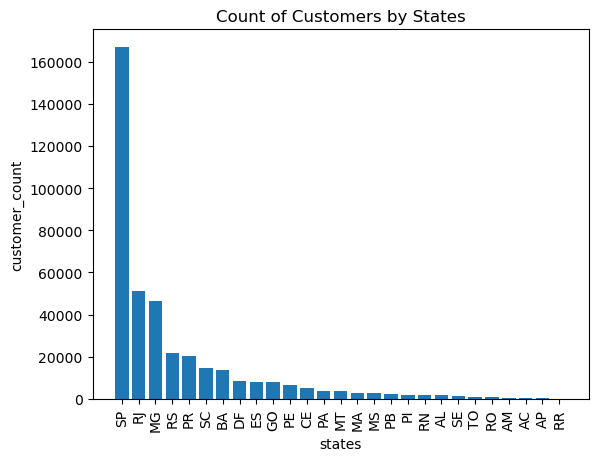

<Figure size 900x400 with 0 Axes>

In [14]:
plt.bar(dff['customer_state'],dff['cu_count'])
plt.xticks(rotation = 90)

plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")

plt.figure(figsize = (9,4))
plt.show()

# Calculate the number of orders per month in 2018.

In [15]:
query = """select monthname(order_purchase_timestamp), count(order_id) from ecommerce.orders
where year(order_purchase_timestamp) = 2018
group by monthname(order_purchase_timestamp)"""

cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data, columns = ['Month','orders'])
df



,Month,orders
0,July,25168
1,August,26048
2,February,26912
3,June,24668
4,March,28844
5,January,29076
6,May,27492
7,April,27756
8,September,64
9,October,16


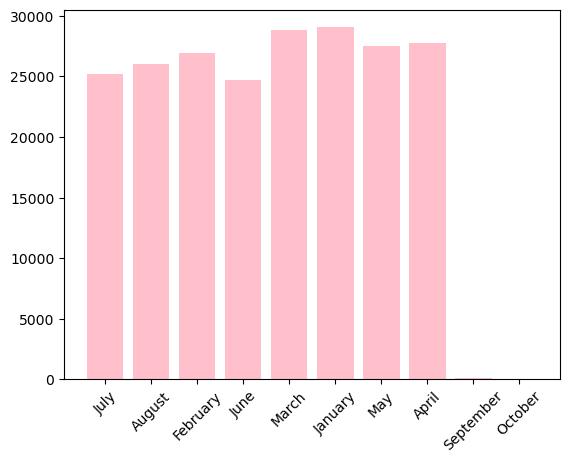

In [16]:
plt.bar(df['Month'],df['orders'], color='pink')
plt.xticks(rotation = 45)
plt.show()

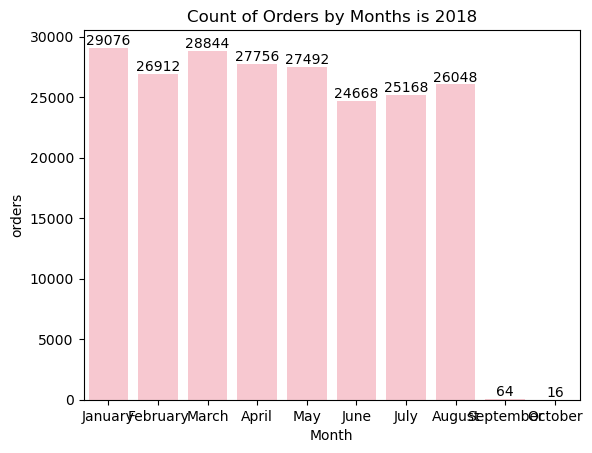

<Figure size 3000x400 with 0 Axes>

In [17]:
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax=sns.barplot(x=df['Month'],y=df['orders'], color='pink', data = df, order = o)
#plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])

plt.title("Count of Orders by Months is 2018")
plt.figure(figsize = (30,4))
plt.show()

# Find the average number of products per order, grouped by customer city.

In [18]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city 
order by average_orders desc
"""

cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data, columns = ['Customer City','average count'])
df

,Customer City,average count
0,padre carvalho,56.00
1,celso ramos,52.00
2,datas,48.00
3,candido godoi,48.00
4,matias olimpio,40.00
...,...,...
4105,sao mamede,8.00
4106,sambaiba,8.00
4107,japaratuba,8.00
4108,tuiuti,8.00


# Calculate the percentage of total revenue contributed by each product category.

In [19]:
query = """ SELECT upper(products.product_category) as prod_cat, ROUND((SUM(payments.payment_value) / (SELECT SUM(payment_value) from ecommerce.payments)) * 100,2) AS sales_percentage
FROM ecommerce.products 
JOIN ecommerce.order_items ON products.product_id = order_items.product_id
JOIN ecommerce.payments ON order_items.order_id = payments.order_id
GROUP BY prod_cat
order by sales_percentage desc """

cur.execute(query)
data=cur.fetchall()

df=pd.DataFrame(data, columns = ['Product Category','Sales Percentage'])

df


,Product Category,Sales Percentage
0,BED TABLE BATH,85.58
1,HEALTH BEAUTY,82.82
2,COMPUTER ACCESSORIES,79.22
3,FURNITURE DECORATION,71.47
4,WATCHES PRESENT,71.42
...,...,...
69,PC GAMER,0.11
70,HOUSE COMFORT 2,0.09
71,CDS MUSIC DVDS,0.06
72,FASHION CHILDREN'S CLOTHING,0.04


# Identify the correlation between product price and the number of times a product has been purchased.

In [20]:
import numpy as np

In [21]:
# 1st calculate the no. of times a particular product has been bought
# to find corelation between

query = """ select products.product_category, count(order_items.product_ID) , round(avg(price),2) from ecommerce.products
join ecommerce.order_items on products.product_id = order_items.product_id
group by products.product_category """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])
df

arr1 = df['order_count']
arr2 = df['price']

a = np.corrcoef ([arr1,arr2])
a
print()
print("the correlation is", a[0][-1])


the correlation is -0.10631514167157562


In [22]:
# no relation ( no impact of order count on order price

# Calculate the total revenue generated by each seller, and rank them by revenue.

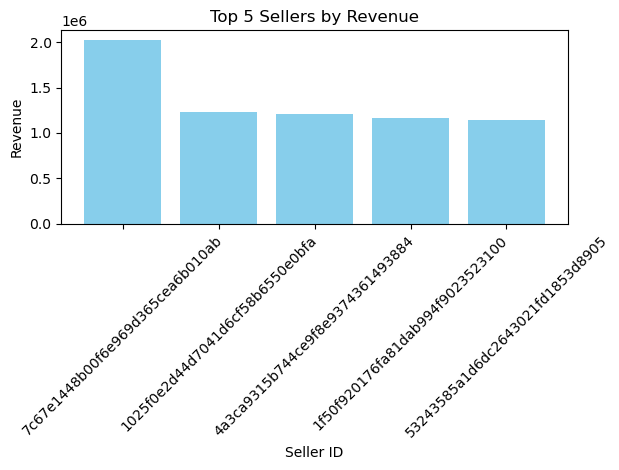

In [23]:
query = """ select a.* , dense_rank() over(order by a.revenue desc) as rn
from
(select order_items.seller_id, round(sum(payments.payment_value),2 ) as revenue from ecommerce.order_items
join ecommerce.payments on order_items.order_ID = payments.order_ID
group by order_items.seller_id) a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Seller ID", "Seller Revenue","Rank"])
df = df.head()
df

plt.bar( df["Seller ID"], df["Seller Revenue"], color='skyblue' )
plt.xlabel("Seller ID")
plt.ylabel("Revenue")
plt.title("Top 5 Sellers by Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [24]:
query = """ select a.* , avg(a.payment_value) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id , orders.order_purchase_timestamp , payments.payment_value from ecommerce.payments
join ecommerce.orders on payments.order_id = orders.order_id) a """


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
831083,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
831084,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
831085,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
831086,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

In [25]:
query = """ select a.* , sum(amt) over ( partition by yr order by yr, mt)
from
(select year(orders.order_purchase_timestamp) as yr , month(orders.order_purchase_timestamp) mt, round(sum(payments.payment_value),2) as amt
from ecommerce.orders
join ecommerce.payments on orders.order_ID = payments.order_ID
group by yr,mt
order by yr,mt) a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,2017.92,2017.92
1,2016,10,472723.84,474741.76
2,2016,12,156.96,474898.72
3,2017,1,1107904.32,1107904.32
4,2017,2,2335264.08,3443168.40
5,2017,3,3598908.80,7042077.20
6,2017,4,3342304.24,10384381.44
7,2017,5,4743350.56,15127732.00
8,2017,6,4090211.04,19217943.04
9,2017,7,4739063.36,23957006.40


# Calculate the year-over-year growth rate of total sales.

In [26]:
query = """ with a as (select year(orders.order_purchase_timestamp) yr, round(sum(payments.payment_value),2) as sales
from ecommerce.orders
join ecommerce.payments on orders.order_id = payments.order_id
group by yr
order by sales )

select yr, sales, 
lag(sales,1) over (order by sales ) prev_yr, 
((sales - lag(sales,1) over (order by sales ))/ lag(sales,1) over (order by sales ))*100  yoy_sales
from a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","sales","prev_yr_sales", "yoy % growth"])
df

,years,sales,prev_yr_sales,yoy % growth
0,2016,474898.72,NaN,NaN
1,2017,57997973.83,474898.72,12112.703759
2,2018,69598104.41,57997973.83,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [27]:
query = """ with a as (select customers.customer_id, min(orders.order_purchase_timestamp) first_order from ecommerce.customers
join ecommerce.orders on orders.customer_id = customers.customer_id
group by customers.customer_id ),

b as (select a.customer_id ,count(distinct orders.order_purchase_timestamp) next_orders
from a join ecommerce.orders
on orders.customer_id = a.customer_id
where orders.order_purchase_timestamp > a.first_order
AND orders.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
GROUP BY a.customer_id) 

select 100 * (count(distinct a.customer_id) / count(distinct b.customer_id))
from a left join b 
on a.customer_id = b.customer_id; """

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

In [28]:
query = """ select a.* from
(select year(orders.order_purchase_timestamp) yr, orders.customer_id, sum(payments.payment_value) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc ) as d_rank
from ecommerce.orders
join ecommerce.payments on  orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp), orders.customer_id) a
where d_rank <= 3 """ 

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","cu_id","payment","rank"])

df

,years,cu_id,payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,11388.400391,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,11205.919922,2
2,2016,4a06381959b6670756de02e07b83815f,9822.240234,3
3,2017,1617b1357756262bfa56ab541c47bc16,109312.640625,1
4,2017,c6e2731c5b391845f6800c97401a43a9,55434.480469,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,53813.281250,3
6,2018,ec5b2ba62e574342386871631fafd3fc,58199.039062,1
7,2018,f48d464a0baaea338cb25f816991ab1f,55377.679688,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,38475.519531,3


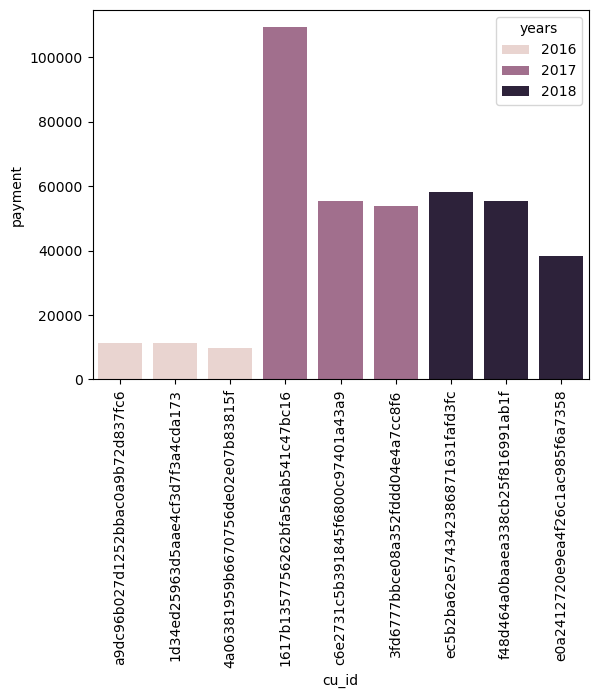

In [29]:
sns.barplot( x="cu_id" , y = "payment" , data=df, hue = "years")
plt.xticks(rotation = 90)
plt.show()